# Notebook on time series causality, part 3

We are interested in estimating effect of exogenous process $u_{t}$ on subsequent values of variable $y_{2}$, namely $y_{2,t+1}$ and $y_{2,t+2}$.

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

In [3]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## DGP

$
\begin{align*}
Y_{1,t} & = b_{1,1} Y_{1,t-1} + b_{1,3} Y_{3,t-1} + u_{1,t} \\
Y_{2,t} & = b_{2,1} Y_{1,t-1} + b_{2,2} Y_{2,t-1} + b_{2,3} Y_{3,t-1} + u_{2,t} + u_{1,t} \\
Y_{3,t} & = b_{3,3} Y_{3,t-1} + u_{3,t} + u_{1,t} \\
\end{align*}
$

where $t \geq 1$ and $
\begin{align*}
Y_0 = \begin{bmatrix} Y_{1,0} \\ Y_{2,0} \\ Y_{3,0} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
\end{align*}
$

and with $b_{1,1} = 0.8$, $b_{1,3} = -0.55$, $b_{2,1} = -0.50$, $b_{2,2} = 0.7$, $b_{2,3} = -0.85$ and $b_{3,3} = -0.40$. 

Shocks correlation matrix:

$
\begin{align*}
\mathbf{\Sigma}_u = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{align*}
$

In this DGP $Y_{1,t}$ and $Y_{2,t}$ are correlated through $Y_{1,t-1}$.

We are interested in effects $u_{1,t} \rightarrow y_{2,t+1}$ and $u_{1,t} \rightarrow y_{2,t+2}$. According to DGP the true affects are
 - $u_{1,t} \rightarrow y_{2,t+1}$: $1 * b_{2,1} + 1 * b_{2,2} + 1 * b_{2,2}$
 - $u_{1,t} \rightarrow y_{2,t+2}$: Sum of
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: $1*b_{1,1}*b_{2,1}$
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: $1*b_{2,1}*b_{2,2}$
   - $u_{1,t} \rightarrow y_{1,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: $1*b_{3,1}*b_{2,3}$
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: $1*b_{1,2}*b_{2,1}$ 
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: $1*b_{2,2}*b_{2,2}$
   - $u_{1,t} \rightarrow y_{2,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: $1*b_{3,2}*b_{2,3}$
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{1,t+1} \rightarrow y_{2,t+2}$: $1*b_{1,2}*b_{2,1}$
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{2,t+1} \rightarrow y_{2,t+2}$: $1*b_{2,3}*b_{2,2}$
   - $u_{1,t} \rightarrow y_{3,t} \rightarrow y_{3,t+1} \rightarrow y_{2,t+2}$: $1*b_{3,4}*b_{2,3}$

In [4]:
# Coefficients
coefs = np.array([
       [0.80, 0, -0.55], 
       [-0.50, 0.70, -0.85],
       [0, 0, -0.40],       
])

true_u1t_y2t1 = sum(coefs[1, :])
true_u1t_y2t2 = sum([
    coefs[0, 0] * coefs[1, 0],
    coefs[1, 0] * coefs[1, 1],
    coefs[2, 0] * coefs[1, 2],
    coefs[0, 1] * coefs[1, 0],
    coefs[1, 1] * coefs[1, 1],
    coefs[2, 1] * coefs[1, 2],
    coefs[0, 2] * coefs[1, 0],
    coefs[1, 2] * coefs[1, 1],
    coefs[2, 2] * coefs[1, 2],
])
print("True effect  u1_t -> y2_t+1 is: {:.3f}".format(true_u1t_y2t1))
print("True effect  u1_t -> y2_t+2 is: {:.3f}".format(true_u1t_y2t2))

True effect  u1_t -> y2_t+1 is: -0.650
True effect  u1_t -> y2_t+2 is: -0.240


Directed acyclic graph of the DGP:

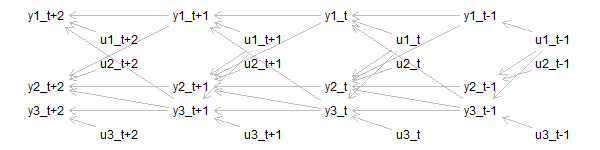

[1] "Adjustment set for u1_t direct effect on y2_t+1:"
 { y1_t, y2_t, y3_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for u1_t direct effect on y2_t+2:"
 { y1_t+1, y2_t+1, y3_t+1 }
 { u1_t+1, y1_t+1, y2_t+1, y3_t }
 { u1_t+1, y1_t, y2_t+1, y3_t }
 { y1_t, y2_t, y3_t }
[1] "--------------------"
[1] "Adjustment set for u1_t total effect on y2_t+2:"
 {}


In [5]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "u1_t+2" [pos="1,2"]
    "u2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "u1_t+1" [pos="3,2"]
    "u2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "u1_t"   [pos="5,2"]
    "u2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "u1_t-1" [pos="7,2"]
    "u2_t-1" [pos="7,3"]
    "y3_t+2" [pos="0,5"]
    "u3_t+2" [pos="1,6"]
    "y3_t+1" [pos="2,5"]
    "u3_t+1" [pos="3,6"]      
    "y3_t"   [pos="4,5"]
    "u3_t"   [pos="5,6"]      
    "y3_t-1" [pos="6,5"]
    "u3_t-1" [pos="7,6"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "u1_t+2"
    "y1_t+1" <- "u1_t+1"
    "y1_t"   <- "u1_t"
    "y1_t-1" <- "u1_t-1"
    "y2_t+2" <- "u2_t+2"
    "y2_t+1" <- "u2_t+1"
    "y2_t"   <- "u2_t"
    "y2_t-1" <- "u2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "y3_t+1" -> "y2_t+2"
    "y1_t+1" <- "y3_t" -> "y2_t+1"
    "y1_t"   <- "y3_t-1" -> "y2_t"
    "y3_t+2" <- "y3_t+1"
    "y3_t+1" <- "y3_t"
    "y3_t"   <- "y3_t-1"
    "y3_t+2" <- "u3_t+2"
    "y3_t+1" <- "u3_t+1"
    "y3_t"   <- "u3_t"
    "y3_t-1" <- "u3_t-1"
    "y2_t+1" <- "u1_t+1"
    "y2_t"   <- "u1_t"
    "y2_t-1" <- "u1_t-1"
    "y3_t+1" <- "u1_t+1"
    "y3_t"   <- "u1_t"
    "y3_t-1" <- "u1_t-1"
}')
plot(g)
print("Adjustment set for u1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for u1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for u1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="u1_t", outcome="y2_t+2", effect="total"))

### Simualate data according to DGP

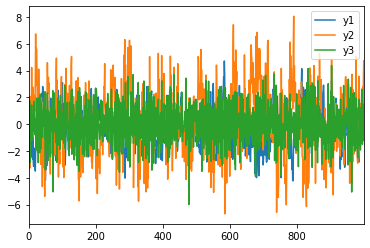

In [6]:
no_obs = 1000
initial_state = np.array([[0, 0, 0]]).T

# Generate array of u's
u_means = [0 ,0, 0]
u_stds = [1, 1, 1]
corrmat = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 1]
]
covmat = corr2cov(corrmat, u_stds)
u_array = np.random.multivariate_normal(
    mean=u_means,
    cov=covmat,
    size=no_obs-1
)

# Allocate aray for data
data_array = np.empty([no_obs, 3])
data_array[:] = np.nan
data_array[0, :] = initial_state.T

# Simulate data
for i in range(1, no_obs):
    # Error terms s in DGP
    shocks = u_array[i-1, :, np.newaxis]
    shocks[1, 0] = shocks[1, 0] + shocks[0, 0]
    shocks[2, 0] = shocks[2, 0] + shocks[0, 0]
    # Endognous variables 
    data_array[i, :] = (np.matmul(coefs, data_array[i-1, :, np.newaxis]) + shocks).T

df = pd.DataFrame(data_array, columns=["y1", "y2", "y3"])
_ = df.plot()

## Model 1: "Perfect model"

In first model we "guess" the structure correctly and fit a 3-variable reduced-form VAR(1) process to simulated data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
Y_{3,t} & = \beta_{3,1} Y_{1,t-1} + \beta_{3,2} Y_{2,t-1}+ \beta_{3,3} Y_{3,t-1} + \epsilon_{3,t} \\
\end{align*}
$

For structural identification/impulse responses we use Wold causal ordering (Cholesky decomposition) such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \\ \epsilon_{3,t} \end{bmatrix} = \begin{bmatrix} ? & 0 & 0 \\ ? & ? & 0 \\ ? & ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \\ \omega_{3,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [7]:
model1_var = sm.tsa.VAR(df)
res1_var = model1_var.fit(maxlags=1)
irf1_var = res1_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0, 0],
    ["E", "E", 0],
    ["E", "E", "E"],
])
model1_svar = sm.tsa.SVAR(df.copy(), svar_type='A', A=D)
res1_svar = model1_svar.fit(maxlags=1)
irf1_svar = res1_svar.irf(5)

### Estimation results - coefficients and residuals

Coefficients fairly well estimated.

In [8]:
res1_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Sep, 2020
Time:                     18:29:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.148225
Nobs:                     999.000    HQIC:                  0.111687
Log likelihood:          -4285.16    FPE:                    1.09339
AIC:                    0.0892849    Det(Omega_mle):         1.08036
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.023536         0.031191           -0.755           0.450
L1.y1         0.841204         0.026056           32.284           0.000
L1.y2         0.004126         0.014983            0.275           0.783
L1.y3        -0.565577

### Reduced-form residuals and structural shocks from SVAR

In [9]:
display(pd.DataFrame(np.corrcoef(res1_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid1_structural = pd.DataFrame(np.matmul(res1_svar.A, res1_svar.resid.T).T, columns=df.columns, index=list(range(1, len(res1_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid1_structural, rowvar=False)))

,0,1,2
0,1.000000,0.625692,0.697584
1,0.625692,1.000000,0.664165
2,0.697584,0.664165,1.000000


,0,1,2
0,1.000000,-0.000002,0.000003
1,-0.000002,1.000000,-0.000002
2,0.000003,-0.000002,1.000000


### Structural impulse responses and structural impact multiplier matrix

There are two ways we can plot the structural impulse responses: structural impulse responses from SVAR model and orthogonalized impulse responses from VAR model. As our SVAR identification scheme is Wold causal ordering, results coincide and we show here only the former.

Our identification scheme allows for contemporaneous cross-effects $\omega_{2,t} \rightarrow y_{3,t}$ although in the DGP there is no such effect. We estimate a sizeable effect though, which is bad!

Estimated effects $\omega_{1,t} \rightarrow y_{2,t+1}$ and $\omega_{1,t} \rightarrow y_{2,t+2}$ correspond quite well to true effects $u_{1,t} \rightarrow y_{2,t+1}$ and $u_{1,t} \rightarrow y_{2,t+2}$. This is obviously due to the fact that we have estimates a "perfect" model.

Estimated impact multiplier matrix is

In [10]:
display(pd.DataFrame(np.linalg.inv(res1_svar.A)))

,0,1,2
0,0.973786,0.000000,0.000000
1,0.967663,1.206410,0.000000
2,0.943219,0.394669,0.884771


Estimated effect of w1_t on y2_t+1 is about -0.55, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.21, while true value is -0.24


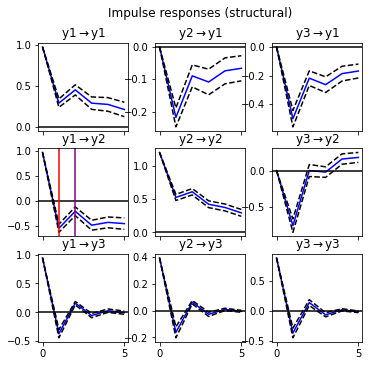

In [11]:
fig = irf1_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
ax = fig.get_axes()[3]
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {:.2f}".format(irf1_svar.svar_irfs[1, 1, 0], true_u1t_y2t1))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {:.2f}".format(irf1_svar.svar_irfs[2, 1, 0], true_u1t_y2t2))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

We recover quite well the result from impulse response.

In [12]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift()
gg["y2_l1"] = gg["y2_l1"].shift()
gg["y3_l1"] = gg["y3_l1"].shift()
gg["w1_l1"] = resid1_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.052
Method:                 Least Squares   F-statistic:                              56.13
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    1.49e-13
Time:                        18:29:52   Log-Likelihood:                         -2308.6
No. Observations:                 998   AIC:                                      4619.
Df Residuals:                     997   BIC:                                      4624.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? In this case the estimated coefficient for $\omega_{1,t}$ would reveal the *direct* effect on $y_{2,t+1}$, which is estimated around zero as expected. Estimates for coefficients of lagged endogenous variables are fairly accurate.

Notice that if we are interested in the total effect of $u_{1,t}$ (using its estimate $\omega_{1,t}$) on $y_{2,t+1}$, it would be a grave mistake to control for *any* of $y_{1,t}$/$y_{2,t}$/$y_{3,t}$ as this would introduce bias due to "adjustment for an intermediate or a descendant of an intermediate" (see Appendix A).

In [13]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.623
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                              410.6
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   9.17e-209
Time:                        18:29:52   Log-Likelihood:                         -1849.2
No. Observations:                 998   AIC:                                      3706.
Df Residuals:                     994   BIC:                                      3726.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Checks out fairly well.

In [14]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(2)
gg["y2_l1"] = gg["y2_l1"].shift(2)
gg["y3_l1"] = gg["y3_l1"].shift(2)
gg["w1_l2"] = resid1_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              9.438
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                     0.00218
Time:                        18:29:52   Log-Likelihood:                         -2329.0
No. Observations:                 997   AIC:                                      4660.
Df Residuals:                     996   BIC:                                      4665.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$, $y_{2, t}$ and $y_{3, t}$? We would get *direct* effect of $\omega_{1, t}$, which is estimated around zero as expected. As in case above, if one controls for any of $y_{1, t}$/$y_{2, t}$/$y_{3, t}$ this will introduce bias.

In [15]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y3_l1 + w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.426
Model:                            OLS   Adj. R-squared (uncentered):              0.424
Method:                 Least Squares   F-statistic:                              184.3
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   3.90e-118
Time:                        18:29:52   Log-Likelihood:                         -2056.9
No. Observations:                 997   AIC:                                      4122.
Df Residuals:                     993   BIC:                                      4141.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Model 2: Model with 2 variables

In second model we treat variable $Y_{3}$ as unobserved. We fit a 2-variable reduced-form VAR(1) process to simulated data:

$
\begin{align*}
Y_{1,t} & = \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{1,t-1}+ \beta_{1,3} Y_{3,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1}+ \beta_{2,3} Y_{3,t-1} + \epsilon_{2,t} \\
\end{align*}
$

For structural identification/impulse responses we use Cholesky decomposition such that

$
\begin{align*}
\begin{bmatrix} \epsilon_{1,t}  \\ \epsilon_{2,t} \end{bmatrix} = \begin{bmatrix} ? & 0 \\ ? & ? \end{bmatrix} \begin{bmatrix} \omega_{1,t} \\ \omega_{2,t} \end{bmatrix}
\end{align*}
$

Estimate VAR and similar SVAR:

In [16]:
# VAR
model2_var = sm.tsa.VAR(df[["y1", "y2"]])
res2_var = model2_var.fit(maxlags=1)
irf2_var = res2_var.irf(5)

# SVAR
D = np.asarray([
    ["E", 0],
    ["E", "E"],
])
model2_svar = sm.tsa.SVAR(df[["y1", "y2"]].copy(), svar_type='A', A=D)
res2_svar = model2_svar.fit(maxlags=1)
irf2_svar = res2_svar.irf(5)

### Estimation results - coefficients and residuals

Coefficients not that well estimated.

In [17]:
res2_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Sep, 2020
Time:                     18:29:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.718657
Nobs:                     999.000    HQIC:                  0.700388
Log likelihood:          -3173.29    FPE:                    1.99210
AIC:                     0.689187    Det(Omega_mle):         1.98018
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.032974         0.036558           -0.902           0.367
L1.y1         0.550135         0.024926           22.070           0.000
L1.y2        -0.159685         0.014483          -11.025           0.000

Results for equation 

### Reduced-form residuals and structural shocks from SVAR

In [18]:
display(pd.DataFrame(np.corrcoef(res2_svar.resid, rowvar=False)))
# Put structural shocks into data frame; make sure time index matches as series is of length len(df)-1
resid2_structural = pd.DataFrame(np.matmul(res2_svar.A, res2_svar.resid.T).T, columns=df.columns[:2], index=list(range(1, len(res2_svar.resid)+1)))
display(pd.DataFrame(np.corrcoef(resid2_structural, rowvar=False)))

,0,1
0,1.000000,0.723347
1,0.723347,1.000000


,0,1
0,1.000000e+00,-1.685564e-08
1,-1.685564e-08,1.000000e+00


### Structural impulse responses and structural impact multiplier matrix

As one can expect, due to a missing variable the SVAR model does not recover correct exogenous processes.

Our identification scheme correctly assumes that there is only one exogenous process driving $y_1$. Further, identification scheme allows for both $\omega_{1,t}$ and $\omega_{2,t}$ to affect $y_{2,t}$. Since we are missing the 3rd variable, we do not have an estimate for $u_{3,t}$ and its effect on $y_{1,t}$ and $y_{2,t}$ is incorrectly baked into estimates $\omega_{1,t}$ and $\omega_{2,t}$. That is, $\omega_1$ and $\omega_2$ represent some combination of true exogenous processes $u_1$, $u_2$ and $u_3$.

Both effect of $\omega_{1,t}$ on $y_{1,t}$ and $\omega_{2,t}$ on $y_{2,t}$ are inflated due to latent influence of $u_{3,t}$. What about our effects of interest, $u_{1,t} \rightarrow y_{2,t+1}$ and $u_{1,t} \rightarrow y_{2,t+2}$; Does $\omega_{1,t}$ offer a good estimate for $u_{1,t}$ in this regard? From impulse responses we see that while the general shape of impulse response of $y_{2}$ on $\omega_{1,t}$ is alright, values are estimated with bias. For example, the first two values are biased upward and 3rd downward.

Estimated impact multiplier matrix is

In [19]:
display(pd.DataFrame(np.linalg.inv(res2_svar.A)))

,0,1
0,1.141486,6.311992e-17
1,1.291442,1.232769e+00


Estimated effect of w1_t on y2_t+1 is about -0.41, while true value is -0.65
Estimated effect of w1_t on y2_t+2 is about -0.57, while true value is -0.24


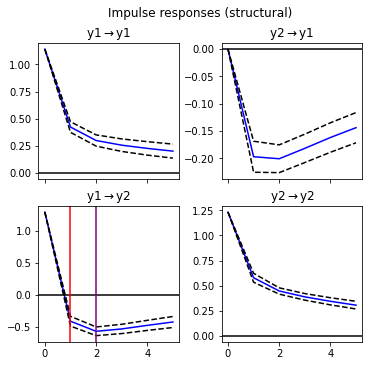

In [20]:
fig = irf2_svar.plot()
fig.suptitle(fig._suptitle.get_text(), fontsize=12)
fig.set_size_inches(5, 5)
plt.subplots_adjust(top=0.88, wspace=0.3)
_, _, ax, _ = fig.get_axes()
ax.axvline(x=1, c="r")
ax.axvline(x=2, c="purple")
print("Estimated effect of w1_t on y2_t+1 is about {:.2f}, while true value is {:.2f}".format(irf2_svar.svar_irfs[1, 1, 0], true_u1t_y2t1))
print("Estimated effect of w1_t on y2_t+2 is about {:.2f}, while true value is {:.2f}".format(irf2_svar.svar_irfs[2, 1, 0], true_u1t_y2t2))

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+1}$ from impulse responses with a simple linear regression

Simple linear regression recovers about same estimate of the impulse responses (even somewhat more accurate).

In [21]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l1"] = resid2_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              36.49
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    2.17e-09
Time:                        18:29:53   Log-Likelihood:                         -2318.0
No. Observations:                 998   AIC:                                      4638.
Df Residuals:                     997   BIC:                                      4643.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? Effect for $\omega_{1,t}$ on $y_{2, t+1}$ is now closer to its true value! What is going on?

If we knew the underlying exogenous process $u_1$, then the fact that $y_3$ is now latent does not change how we should run the regression if we are interested in total effect of $u_{1,t} \rightarrow y_{2,t+1}$: controlling for $y_{1, t}$ and $y_{2, t}$ would lead to biased results due to "adjustment for an intermediate or a descendant of an intermediate" (see Appendix B).

Of course without imperfect SVAR model we only know $\omega_{1,t}$, not $u_{1,t}$. Question: Does this make a difference whether we should control for $y_{1,t}$/$y_{2,t}$ or not, if we are interested in the (true) effect of $u_{1,t}$? My intuition says no; maybe in this example we are just lucky that introducing bias through linear regression we cancel some of the bias resulting from mis-specified SVAR? But if this is the case, could we utilize this in some scenario and make biases cancel each other out, suggesting we *should* control for $y_{1,t}$/$y_{2,t}$? This would require knowing how we are biasing the system, which, in reality, is a mug's game. If we can be confident about $\omega_{1}$ being a close enough estimate for $u_1$, then controlling for $y_{1,t}$/$y_{2,t}$ will always introduce bias in estimation of total effect.

In [22]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.502
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              334.4
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   3.85e-150
Time:                        18:29:53   Log-Likelihood:                         -1987.9
No. Observations:                 998   AIC:                                      3982.
Df Residuals:                     995   BIC:                                      3997.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Replicate result of $\omega_{1,t}$ total effect on $y_{2, t+2}$ from impulse responses with a simple linear regression

Quite god estimate, much better than what impulse response yields. Not sure why.

However, if in the DGP we had $b_{2,3}=0.85$ instead of $b_{2,3}=-0.85$, the linear regression estimate would be quite bad, much worse than impulse response that actually yields quite good estimate. Again not sure why this happens. 

In [23]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["w1_l2"] = resid2_structural["y1"].copy().shift(2)
gg.dropna(inplace=True)

# Run OLS regression
ols_res = sm_form.ols(formula="y2 ~ w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              9.365
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                     0.00227
Time:                        18:29:53   Log-Likelihood:                         -2329.1
No. Observations:                 997   AIC:                                      4660.
Df Residuals:                     996   BIC:                                      4665.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

What would happen if we controlled for $y_{1, t}$ and $y_{2, t}$? We get wildly biased estimate for the effect of $\omega_{1,t}$!

In [24]:
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + w1_l2 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.515
Model:                            OLS   Adj. R-squared (uncentered):              0.514
Method:                 Least Squares   F-statistic:                              352.0
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   1.02e-155
Time:                        18:29:53   Log-Likelihood:                         -1972.9
No. Observations:                 997   AIC:                                      3952.
Df Residuals:                     994   BIC:                                      3966.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

## Appendix

### Appendix A

If we are interested in the total effect of $u_{1,t}$/$\omega_{1,t}$ on $y_{2,t+1}$, it would be a mistake to control for *any* of $y_{1,t}$/$y_{2,t}$/$y_{3,t}$ as this would introduce bias due to "adjustment for an intermediate or a descendant of an intermediate" (here we use estimated $\omega_{1,t}$$ from the "perfect" model). 

In [25]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["y3_l1"] = gg["y3_l1"].shift(1)
gg["w1_l1"] = resid1_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Run OLS regression
#ols_res = sm_form.ols(formula="y2 ~  w1_l1 -1", data=gg).fit()
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + w1_l1 -1", data=gg).fit()
#ols_res = sm_form.ols(formula="y2 ~ y2_l1 + w1_l1 -1", data=gg).fit()
#ols_res = sm_form.ols(formula="y2 ~ y3_l1 + w1_l1 -1", data=gg).fit()
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.304
Model:                            OLS   Adj. R-squared (uncentered):              0.302
Method:                 Least Squares   F-statistic:                              217.2
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    5.02e-79
Time:                        18:29:53   Log-Likelihood:                         -2155.3
No. Observations:                 998   AIC:                                      4315.
Df Residuals:                     996   BIC:                                      4324.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Appendix B
If interested in effect of $u_{1,t}$ on $y_{2, t+1}$, controlling for any of $y_{1,t}$/$y_{2,t}$/$y_{3,t}$ renders estimation of total effect invalid due to "adjustment for an intermediate or a descendant of an intermediate"!

In [26]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y2"] = df["y2"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["y3_l1"] = gg["y3_l1"].shift(1)
gg["u1_l1"] = u_array[:, 0]
gg["u1_l1"] = gg["u1_l1"].shift(1)
gg.dropna(inplace=True)

# Regression
#ols_res = sm_form.ols(formula="y2 ~ u1_l1 - 1", data=gg).fit() # correct result for total effect
ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + u1_l1 - 1", data=gg).fit() # biased result
print(ols_res.summary())

OLS Regression Results                                
Dep. Variable:                     y2   R-squared (uncentered):                   0.507
Model:                            OLS   Adj. R-squared (uncentered):              0.505
Method:                 Least Squares   F-statistic:                              340.8
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   3.35e-152
Time:                        18:29:53   Log-Likelihood:                         -1983.2
No. Observations:                 998   AIC:                                      3972.
Df Residuals:                     995   BIC:                                      3987.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Appendix C

How the two-variable model sees the world. Processes $o_i$ represent hypothetical exogenous processes our model thinks is driving $y_i$, $i=\{ 1,2 \}$.

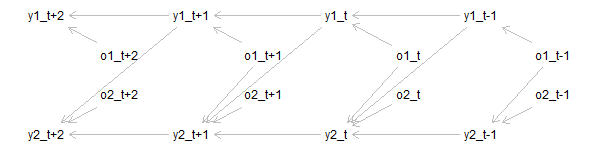

[1] "Adjustment set for o1_t direct effect on y2_t+1:"
 { y1_t, y2_t }
[1] "--------------------"
[1] "Adjustment set for o1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for o1_t direct effect on y2_t+2:"
 { y1_t+1, y2_t+1 }
 { o1_t+1, y1_t, y2_t+1 }
 { y1_t, y2_t }
[1] "--------------------"
[1] "Adjustment set for o1_t total effect on y2_t+2:"
 {}


In [27]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "o1_t+2" [pos="1,2"]
    "o2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "o1_t+1" [pos="3,2"]
    "o2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "o1_t"   [pos="5,2"]
    "o2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "o1_t-1" [pos="7,2"]
    "o2_t-1" [pos="7,3"]
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "o1_t+2"
    "y1_t+1" <- "o1_t+1"
    "y1_t"   <- "o1_t"
    "y1_t-1" <- "o1_t-1"
    "y2_t+2" <- "o2_t+2"
    "y2_t+1" <- "o2_t+1"
    "y2_t"   <- "o2_t"
    "y2_t-1" <- "o2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y2_t+1" <- "o1_t+1"
    "y2_t"   <- "o1_t"
    "y2_t-1" <- "o1_t-1"
}')
plot(g)
print("Adjustment set for o1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for o1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for o1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for o1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+2", effect="total"))

If we add the processes of DGP which are latent to the model, we have something like below. Laten variable $U_1$ corresponds to $u_3$ of DGP and $U_2$ to $y_2$. Here we draw arrow $o_{1,t} \rightarrow U_{2,t}$ although our model does not account for it, but it is there in the true DGP.

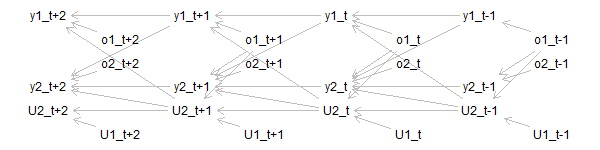

[1] "Adjustment set for o1_t direct effect on y2_t+1:"
[1] "--------------------"
[1] "Adjustment set for o1_t total effect on y2_t+1:"
 {}
[1] "---------------------------------------------------------------------"
[1] "Adjustment set for o1_t direct effect on y2_t+2:"
[1] "--------------------"
[1] "Adjustment set for o1_t total effect on y2_t+2:"
 {}


In [28]:
%%R -h 150 -w 600
g = dagitty( 'dag {
    "y1_t+2" [pos="0,1"]
    "y2_t+2" [pos="0,4"]
    "o1_t+2" [pos="1,2"]
    "o2_t+2" [pos="1,3"]
    "y1_t+1" [pos="2,1"]
    "y2_t+1" [pos="2,4"]
    "o1_t+1" [pos="3,2"]
    "o2_t+1" [pos="3,3"]
    "y1_t"   [pos="4,1"]
    "y2_t"   [pos="4,4"]
    "o1_t"   [pos="5,2"]
    "o2_t"   [pos="5,3"]
    "y1_t-1" [pos="6,1"]
    "y2_t-1" [pos="6,4"]
    "o1_t-1" [pos="7,2"]
    "o2_t-1" [pos="7,3"]
    "U2_t+2"[latent pos="0,5"]
    "U1_t+2"[latent pos="1,6"]
    "U2_t+1"[latent pos="2,5"]
    "U1_t+1"[latent pos="3,6"]      
    "U2_t"  [latent pos="4,5"]
    "U1_t"  [latent pos="5,6"]      
    "U2_t-1"[latent pos="6,5"]
    "U1_t-1"[latent pos="7,6"]      
    "y1_t+2" <- "y1_t+1" <- "y1_t" <- "y1_t-1"
    "y2_t+2" <- "y2_t+1" <- "y2_t" <- "y2_t-1"
    "y1_t+2" <- "o1_t+2"
    "y1_t+1" <- "o1_t+1"
    "y1_t"   <- "o1_t"
    "y1_t-1" <- "o1_t-1"
    "y2_t+2" <- "o2_t+2"
    "y2_t+1" <- "o2_t+1"
    "y2_t"   <- "o2_t"
    "y2_t-1" <- "o2_t-1"
    "y2_t+2" <- "y1_t+1"
    "y2_t+1" <- "y1_t"
    "y2_t"   <- "y1_t-1"
    "y1_t+2" <- "U2_t+1" -> "y2_t+2"
    "y1_t+1" <- "U2_t" -> "y2_t+1"
    "y1_t"   <- "U2_t-1" -> "y2_t"
    "U2_t+2" <- "U2_t+1"
    "U2_t+1" <- "U2_t"
    "U2_t"   <- "U2_t-1"
    "U2_t+2" <- "U1_t+2"
    "U2_t+1" <- "U1_t+1"
    "U2_t"   <- "U1_t"
    "U2_t-1" <- "U1_t-1"
    "y2_t+1" <- "o1_t+1"
    "y2_t"   <- "o1_t"
    "y2_t-1" <- "o1_t-1"
    "U2_t+1" <- "o1_t+1"
    "U2_t"   <- "o1_t"
    "U2_t-1" <- "o1_t-1"    
}')
plot(g)
print("Adjustment set for o1_t direct effect on y2_t+1:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+1", effect="direct"))
print("--------------------")
print("Adjustment set for o1_t total effect on y2_t+1:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+1", effect="total"))
print("---------------------------------------------------------------------")
print("Adjustment set for o1_t direct effect on y2_t+2:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+2", effect="direct"))
print("--------------------")
print("Adjustment set for o1_t total effect on y2_t+2:")
print(adjustmentSets(g, exposure="o1_t", outcome="y2_t+2", effect="total"))

### Testing

Test linear regressions with different regressors.

In [29]:
# Prepare data for OLS
gg = pd.DataFrame()
gg["y1"] = df["y1"].copy()
gg["y2"] = df["y2"].copy()
gg["y3"] = df["y3"].copy()
gg["y1_l1"] = df["y1"].copy()
gg["y2_l1"] = df["y2"].copy()
gg["y3_l1"] = df["y3"].copy()
gg["y1_l2"] = df["y1"].copy()
gg["y2_l2"] = df["y2"].copy()
gg["y3_l2"] = df["y2"].copy()
gg = gg.iloc[1:] # remove y_0 row
gg["u1"] = u_array[:, 0]
gg["u1_l1"] = u_array[:, 0]
gg["u1_l2"] = u_array[:, 0]
gg["u1_l1"] = gg["u1_l1"].shift(1)
gg["y1_l1"] = gg["y1_l1"].shift(1)
gg["y2_l1"] = gg["y2_l1"].shift(1)
gg["y3_l1"] = gg["y3_l1"].shift(1)
gg["y1_l2"] = gg["y1_l2"].shift(2)
gg["y2_l2"] = gg["y2_l2"].shift(2)
gg["y3_l2"] = gg["y3_l2"].shift(2)
gg["u1_l2"] = gg["u1_l2"].shift(2)
gg["w1_model1"] = resid1_structural["y1"].copy()
gg["w1_model2"] = resid2_structural["y1"].copy()
gg["w1_l1_model1"] = resid1_structural["y1"].copy().shift(1)
gg["w1_l1_model2"] = resid2_structural["y1"].copy().shift(1)
gg.dropna(inplace=True)

# Observation 1
# With known exogenous processes we recover correct effect in simple linear regressions
# with only exposure and outcome (up to estimation error)
#ols_res = sm_form.ols(formula="y2 ~ u1_l1", data=gg).fit()
#ols_res = sm_form.ols(formula="y2 ~ u1_l2", data=gg).fit()

# Observation 2
# If interested in effect of u1_t on y2_t+2, controlling for any of y1_t/y2_t/y3_t renders estimation of total
# effect invalid due to "adjustment for an intermediate or a descendant of an intermediate"!
#ols_res = sm_form.ols(formula="y2 ~ u1_l2 - 1", data=gg).fit() # correct result for total effect
#ols_res = sm_form.ols(formula="y2 ~ y1_l2 + y2_l2 + u1_l2 - 1", data=gg).fit() # correct result

# Observation 3
# When running the following regression there is only one unblocked causal path u1_t -> y3_t -> y2_t+1
# I am not sure why the estimated coefficient for u1_t-1 does not represent the full effect of this causal path,
# but rather only about a half of it...
#ols_res = sm_form.ols(formula="y2 ~ y1_l1 + y2_l1 + y1_l2 + y2_l2 + y3_l2 + u1_l1 - 1", data=gg).fit()

# Observation 4
# If interested in effect of u1_t on y3_t and one controls either for y1_t or y2_t, one introduces back-door bias.
# To remedy this one also needs to control y3_t-1.
# Still it seems that we do not get the estimate for full effect but rather effect(u1) + effect(y3_l1). Probably
# has to do with time-series structure of the data (u1_l1 affects y3_l1 etc.), but I still quite dont get why.
#ols_res = sm_form.ols(formula="y3 ~ u1 - 1", data=gg).fit()
#ols_res = sm_form.ols(formula="y3 ~ y1 + y2 + u1 - 1", data=gg).fit()
#ols_res = sm_form.ols(formula="y3 ~ y1 + y2 + u1 + y3_l1 - 1", data=gg).fit()

# Observation 5
# At least in this example estimate w1 from misspecified SVAR yeilds pretty accurate instantaneous effect on latent y3
# When controlling for y1 and y2, not so much anymore
ols_res = sm_form.ols(formula="y3 ~ w1_model2 - 1", data=gg).fit()
#ls_res = sm_form.ols(formula="y3 ~ y1 + y2 + w1_model1 + y3_l1 - 1", data=gg).fit()
#ols_res = sm_form.ols(formula="y3 ~ y1 + y2 + w1_model2 + y3_l1 - 1", data=gg).fit()

print(ols_res.summary())


OLS Regression Results                                
Dep. Variable:                     y3   R-squared (uncentered):                   0.486
Model:                            OLS   Adj. R-squared (uncentered):              0.486
Method:                 Least Squares   F-statistic:                              942.9
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                   3.05e-146
Time:                        18:29:53   Log-Likelihood:                         -1469.9
No. Observations:                 997   AIC:                                      2942.
Df Residuals:                     996   BIC:                                      2947.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------